In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, LogLocator

from tqdm.notebook import tqdm

from nufit_params import *

In [2]:
def get_param_samples(n_samples, isNO=True, only_alpha_beta=False):

    if isNO:
        if only_alpha_beta:
            theta12_samples = np.array([theta12]*n_samples)
            theta23_samples = np.array([theta23]*n_samples)
            theta13_samples = np.array([theta13]*n_samples)
            deltaCP_samples = np.array([deltaCP]*n_samples)
            delta2_m21_samples = np.array([delta2_m21]*n_samples)
            delta2_m3l_samples = np.array([delta2_m3l]*n_samples)

        else:
            theta12_samples = np.random.normal(theta12, theta12_err, n_samples)
            theta23_samples = np.random.normal(theta23, theta23_err, n_samples)
            theta13_samples = np.random.normal(theta13, theta13_err, n_samples)
            deltaCP_samples = np.random.normal(deltaCP, deltaCP_err, n_samples)
            delta2_m21_samples = np.random.normal(delta2_m21, delta2_m21_err, n_samples)
            delta2_m21_samples = np.clip(delta2_m21_samples, 0, None) # ensure positive
            delta2_m3l_samples = np.random.normal(delta2_m3l, delta2_m3l_err, n_samples)
            delta2_m3l_samples = np.clip(delta2_m3l_samples, 0, None) # ensure positive
    else:
        if only_alpha_beta:
            theta12_samples = np.array([theta12_inv]*n_samples)
            theta23_samples = np.array([theta23_inv]*n_samples)
            theta13_samples = np.array([theta13_inv]*n_samples)
            deltaCP_samples = np.array([deltaCP_inv]*n_samples)
            delta2_m21_samples = np.array([delta2_m21_inv]*n_samples)
            delta2_m3l_samples = np.array([delta2_m3l_inv]*n_samples)
        else:
            theta12_samples = np.random.normal(theta12_inv, theta12_inv_err, n_samples)
            theta23_samples = np.random.normal(theta23_inv, theta23_inv_err, n_samples)
            theta13_samples = np.random.normal(theta13_inv, theta13_inv_err, n_samples)
            deltaCP_samples = np.random.normal(deltaCP_inv, deltaCP_inv_err, n_samples)
            delta2_m21_samples = np.random.normal(delta2_m21_inv, delta2_m21_err, n_samples)
            delta2_m21_samples = np.clip(delta2_m21_samples, 0, None) # ensure negative
            delta2_m3l_samples = np.random.normal(delta2_m3l_inv, delta2_m3l_inv_err, n_samples)
            delta2_m3l_samples = np.clip(delta2_m3l_samples, None, 0) # ensure positive


    alpha1_samples = np.random.uniform(0, 2*np.pi, n_samples)
    alpha2_samples = np.random.uniform(0, 2*np.pi, n_samples)

    m_min_samples = 10**np.random.uniform(-4, -1, n_samples)

    isNOs = np.array([isNO]*n_samples)

    return np.array([theta12_samples, theta23_samples, theta13_samples, deltaCP_samples, delta2_m21_samples, delta2_m3l_samples, alpha1_samples, alpha2_samples, m_min_samples, isNOs]).T



In [3]:
def get_PMNS(params):

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    rot_23 = np.array([[
        [1, 0, 0],
        [0, np.cos(theta23), np.sin(theta23)],
        [0, -np.sin(theta23), np.cos(theta23)]
        ]])

    rot_13 = np.array([[
        [np.cos(theta13), 0, np.sin(theta13)*np.exp(-1j*deltaCP)],
        [0, 1, 0],
        [-np.sin(theta13)*np.exp(1j*deltaCP), 0, np.cos(theta13)]
        ]])

    rot_12 = np.array([[
        [np.cos(theta12), np.sin(theta12), 0],
        [-np.sin(theta12), np.cos(theta12), 0],
        [0, 0, 1]
        ]])
    
    majorana = np.diag([np.exp(1j*alpha1), np.exp(1j*alpha2), 1])

    return (rot_23 @ rot_13 @ rot_12 @ majorana)[0]


def get_m_min(params):

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    return m_min


def get_m_sum(params):
    # sum(m_i)

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    if isNO:
        m1 = m_min
        m2 = np.sqrt(m1**2 + delta2_m21)
        m3 = np.sqrt(m2**2 + delta2_m3l)
    else:
        m3 = m_min
        m2 = np.sqrt(m3**2 - delta2_m3l)
        m1 = np.sqrt(m2**2 - delta2_m21)

    return m1 + m2 + m3
    

def get_m_bb(params):
    # abs(sum(U_ei^2 m_i))

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    if isNO:
        m1 = m_min
        m2 = np.sqrt(m1**2 + delta2_m21)
        m3 = np.sqrt(m2**2 + delta2_m3l)
    else:
        m3 = m_min
        m2 = np.sqrt(m3**2 - delta2_m3l)
        m1 = np.sqrt(m2**2 - delta2_m21)

    PMNS = get_PMNS(params)

    return np.abs([PMNS[0,0]**2 * m1 + PMNS[0,1]**2 * m2 + PMNS[0,2]**2 * m3])[0]

def get_m_e(params):
    # sqrt(sum(abs(U_ei)^2 m_i^2))

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    if isNO:
        m1 = m_min
        m2 = np.sqrt(m1**2 + delta2_m21)
        m3 = np.sqrt(m2**2 + delta2_m3l)
    else:
        m3 = m_min
        m2 = np.sqrt(m3**2 - delta2_m3l)
        m1 = np.sqrt(m2**2 - delta2_m21)

    PMNS = get_PMNS(params)

    return np.sqrt(np.abs(PMNS[0,0])**2 * m1**2 + np.abs(PMNS[0,1])**2 * m2**2 + np.abs(PMNS[0,2])**2 * m3**2)

def get_m_mu(params):
    # sqrt(sum(abs(U_mui)^2 m_i^2))

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    if isNO:
        m1 = m_min
        m2 = np.sqrt(m1**2 + delta2_m21)
        m3 = np.sqrt(m2**2 + delta2_m3l)
    else:
        m3 = m_min
        m2 = np.sqrt(m3**2 - delta2_m3l)
        m1 = np.sqrt(m2**2 - delta2_m21)

    PMNS = get_PMNS(params)

    return np.sqrt(np.abs(PMNS[1,0])**2 * m1**2 + np.abs(PMNS[1,1])**2 * m2**2 + np.abs(PMNS[1,2])**2 * m3**2)

def get_m_mumu(params):
    # abs(sum(U_mui^2 m_i))

    theta12, theta23, theta13, deltaCP, delta2_m21, delta2_m3l, alpha1, alpha2, m_min, isNO = params

    if isNO:
        m1 = m_min
        m2 = np.sqrt(m1**2 + delta2_m21)
        m3 = np.sqrt(m2**2 + delta2_m3l)
    else:
        m3 = m_min
        m2 = np.sqrt(m3**2 - delta2_m3l)
        m1 = np.sqrt(m2**2 - delta2_m21)

    PMNS = get_PMNS(params)

    return np.abs([PMNS[1,0]**2 * m1 + PMNS[1,1]**2 * m2 + PMNS[1,2]**2 * m3])[0]


In [4]:
NO_params = get_param_samples(10000, isNO=True, only_alpha_beta=False)
NO_m_mins = [get_m_min(p) for p in NO_params]
NO_m_sums = [get_m_sum(p) for p in NO_params]
NO_m_bbs = [get_m_bb(p) for p in NO_params]
NO_m_es = [get_m_e(p) for p in NO_params]
NO_m_mus = [get_m_mu(p) for p in NO_params]
NO_m_mumus = [get_m_mumu(p) for p in NO_params]

IO_params = get_param_samples(10000, isNO=False, only_alpha_beta=False)
IO_m_mins = [get_m_min(p) for p in IO_params]
IO_m_sums = [get_m_sum(p) for p in IO_params]
IO_m_bbs = [get_m_bb(p) for p in IO_params]
IO_m_es = [get_m_e(p) for p in IO_params]
IO_m_mus = [get_m_mu(p) for p in IO_params]
IO_m_mumus = [get_m_mumu(p) for p in IO_params]

for x in NO_m_mins + NO_m_sums + NO_m_bbs + NO_m_es + NO_m_mus + NO_m_mumus + IO_m_mins + IO_m_sums + IO_m_bbs + IO_m_es + IO_m_mus + IO_m_mumus:
    assert x > 0


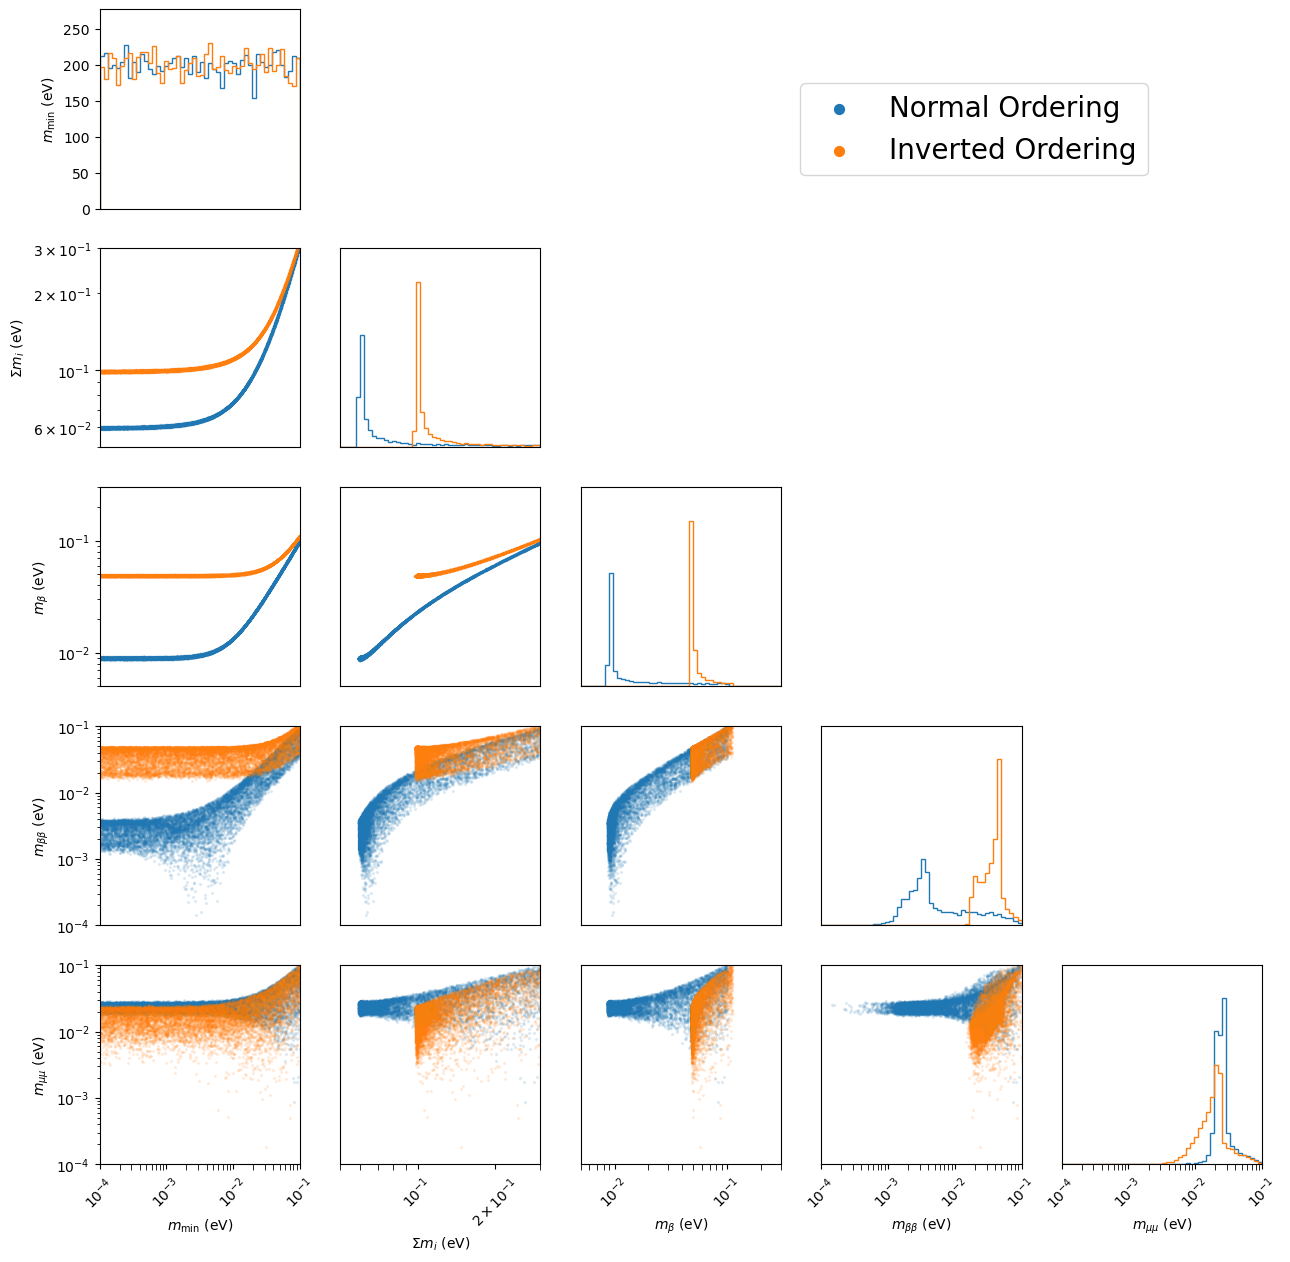

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

ax_mins_maxes = [(1e-4, 1e-1), (5e-2, 3e-1), (5e-3, 3e-1), (1e-4, 1e-1), (1e-4, 1e-1)]

axs_ticks = [[1e-4, 1e-3, 1e-2, 1e-1], [1e-1, 2e-1], [1e-2, 1e-1], [1e-4, 1e-3, 1e-2, 1e-1], [1e-4, 1e-3, 1e-2, 1e-1]]

for i in range(5):
    for j in range(5):

        if j > i:
            axs[i,j].axis('off')
            continue

        # turn ticks off
        axs[i,j].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        if j == 0:
            axs[i,j].set_ylabel([r"$m_\mathrm{min}$ (eV)", r"$\Sigma m_i$ (eV)", r"$m_{\beta}$ (eV)", r"$m_{\beta\beta}$ (eV)", r"$m_{\mu\mu}$ (eV)"][i])
            axs[i,j].tick_params(axis='y', which='both', left=True, labelleft=True)
        if i == 4:
            axs[i,j].set_xlabel([r"$m_\mathrm{min}$ (eV)", r"$\Sigma m_i$ (eV)", r"$m_{\beta}$ (eV)", r"$m_{\beta\beta}$ (eV)", r"$m_{\mu\mu}$ (eV)"][j])
            axs[i,j].tick_params(axis='x', which='both', bottom=True, labelbottom=True)


        if i == j:

            NO_x_vals = [NO_m_mins, NO_m_sums, NO_m_es, NO_m_bbs, NO_m_mumus][j]
            IO_x_vals = [IO_m_mins, IO_m_sums, IO_m_es, IO_m_bbs, IO_m_mumus][j]

            bins = np.logspace(np.log10(ax_mins_maxes[j][0]), np.log10(ax_mins_maxes[j][1]), 51)

            NO_counts, _, _ = axs[i,j].hist(NO_x_vals, bins=bins, histtype='step')
            IO_counts, _, _ = axs[i,j].hist(IO_x_vals, bins=bins, histtype='step')
            

        else:

            NO_x_vals = [NO_m_mins, NO_m_sums, NO_m_es, NO_m_bbs, NO_m_mumus][j]
            NO_y_vals = [NO_m_mins, NO_m_sums, NO_m_es, NO_m_bbs, NO_m_mumus][i]
            IO_x_vals = [IO_m_mins, IO_m_sums, IO_m_es, IO_m_bbs, IO_m_mumus][j]
            IO_y_vals = [IO_m_mins, IO_m_sums, IO_m_es, IO_m_bbs, IO_m_mumus][i]
        
            axs[i,j].scatter(NO_x_vals, NO_y_vals, s=2, alpha=0.1)
            axs[i,j].scatter(IO_x_vals, IO_y_vals, s=2, alpha=0.1)


        axs[i,j].set_xscale("log")
        axs[i,j].set_xlim(ax_mins_maxes[j])

        if i == j:
            axs[i,j].set_ylim(0, np.max([np.max(NO_counts), np.max(IO_counts)]) * 1.2)
        else:
            axs[i,j].set_ylim(ax_mins_maxes[i])
            axs[i,j].set_yscale("log")

        axs[i,j].set_xticks(axs_ticks[j])
        axs[i,j].tick_params(axis='x', rotation=45)

        axs[i,j].xaxis.set_major_locator(FixedLocator(axs_ticks[j]))
        axs[i,j].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
        axs[i,j].tick_params(axis='x', which='minor', length=4, color='k', labelbottom=False)


    if j == 4 and i == 0:
        plt.scatter([np.nan], [np.nan], s=50, label='Normal Ordering')
        plt.scatter([np.nan], [np.nan], s=50, label='Inverted Ordering')

        plt.legend(loc='upper right', bbox_to_anchor=(0.5, 5.5), fontsize=20)

#plt.tight_layout()

plt.savefig("plots/neutrino_mass_correlations.png", dpi=300)
plt.savefig("plots/neutrino_mass_correlations.jpg", dpi=300)
plt.savefig("plots/neutrino_mass_correlations.pdf")
